# Project 03: Clustering Human Recognition

Este proyecto busca detectar qué acción está realizando un humano por medio de un datasets de videos donde se realizan interacciones como: *tocar instrumentos, interacción de humanos con objetos, humanos saludándose, humanos abrazándose, etc*. Para cada acción se cuentan con como mínimo 400 video clips.

---
## 0. Libraries & setup

In [23]:
import os
import glob
import h5py

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
from sklearn.decomposition import PCA
from IPython.core.display import HTML

In [26]:
np.random.seed(11)
HTML("""<style>.output_png { display: table-cell; text-align: center; vertical-align: middle;}</style>""")
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 100
rcParams['grid.linewidth'] = 0.5

sns.set_palette(custom_colors)

---
## 1. Video features extraction

Cada clip tiene asociado con una sola acción humana y dura aproximadamente 10 sgundos. Este proyecto usa un subset del dataset original, se utilizará la librería de Video Fetures y Gluon para extraer las características del video.

Para proceder con el almacenamiento de los datos se utilizará un almacenamiento del tipo **HDF5** por medio de la librería `h5py`. De igual forma se procede a utiizar un modelo etiquetado como: **Action Recognition** para la extracción de características, esto es así pues a comparación del otro modelo **Frame-wise** nosotros tenemos como data acciones dinámicas y no estáticas.

El costo computacional para reconocimiento de acciones será más costoso pues analizará más frames por segundo, por ese motivo se elijió el modelo **S3D (Kinetics 400)**, que si bien no es el más potente o el que brinda más características, pero si aquel que tiene un buen **tradeoff** entre eficiencia y precisión.

Necesitamos **extraer las características** de nuestros videos por medio de la librería que se ejecuta a nivel terminal, con el siguiente comando podremos transformar un listado de videos tal que obtenemos características para cada uno. Es así que contamos en la [documentación](https://v-iashin.github.io/video_features/models/s3d/) con argumentos opcionales, un ejemplo es el siguiente `python main.py feature_type = s3d video_paths="[./qyjw13RCjZk_000017_000027.mp4]" show_pred = true`

In [12]:
labels_df = pd.read_csv('./data/train.csv', header = None, names = ['video_id', 'action'])

video_features_dir = './data/s3d'
video_features = []
video_labels = []
video_empty_frames = 0

for each_video in glob.glob(os.path.join(video_features_dir, '*.npy')):
    video_id = os.path.basename(each_video).split('_')[0]
    current_video_feature = np.load(each_video)

    if current_video_feature.size == 0:
        video_empty_frames += 1
        continue
    
    current_video_feature_avg = np.mean(current_video_feature, axis = 0)    
    video_features.append(current_video_feature_avg)
    
    current_video_label = labels_df[labels_df['video_id'] == video_id]['action'].values[0]
    video_labels.append(current_video_label)

video_features_stacked = np.vstack(video_features)

print(f'Número de videos vacíos no agregados: {video_empty_frames}')
print(f'Número de videos cargados: {len(video_labels)}')
print(f'Shape de nuestra matriz de videos: {video_features_stacked.shape}')

Número de videos vacíos no agregados: 4
Número de videos cargados: 153
Shape de nuestra matriz de videos: (153, 1024)


---
## 2. Data Exploration

Empezaremos creando un objeto dataframe donde vamos a enlazar lo obtenido en nuestra matriz de video con nuestros labels respectivamente que están **asociados al id** del video. De esta manera podemos visualizar nuestra información por medio de funciones como `describe()` ó `head()` inicialmente, para observar los datos obtenidos.

In [21]:
df_train = pd.DataFrame(video_features_stacked)
df_train['action'] = video_labels

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,action
0,0.006259,0.002158,0.000447,0.104054,0.136248,0.002096,0.763180,0.001477,0.013410,0.187355,...,0.016934,0.000000,0.021533,0.106578,0.000000,0.000613,0.215328,0.012362,0.000000,baking cookies
1,0.016030,0.068199,0.046851,0.021842,0.054964,0.017332,0.079560,0.045060,0.033371,0.020106,...,0.127639,0.045394,0.026561,0.035874,0.003803,0.003157,0.000000,0.010185,0.068333,cooking chicken
2,0.000436,0.000000,0.003781,0.005153,0.032376,0.064952,0.125909,0.029724,0.002054,0.036362,...,0.007092,0.001704,0.004300,0.029334,0.021930,1.205938,0.000000,0.011244,0.000204,playing ice hockey
3,0.006103,0.049339,0.002110,0.280927,0.320622,0.000000,0.058010,0.059140,0.002686,0.025240,...,0.105881,0.000798,0.268882,0.033595,0.000804,0.004873,0.003764,0.000000,0.024344,golf driving
4,0.006549,0.012359,0.022782,0.004833,0.008755,0.001654,0.029814,0.197441,0.001310,0.004437,...,0.106427,0.002126,0.022639,0.025599,0.009409,0.000667,0.032731,0.004332,0.125844,dying hair


Si solicitamos las estadísticas descriptivas logramos observar para cada característica / feature su valor en media, cantidad de elementos, desviación estándar, mínimos, máximos, etc. En este caso todas nuestras columnas tienen $153$ elementos, por lo que no hay nulos. Además es posible notar que las medias son distintas, esto quiere decir que hay **diferentes puntos de activación para diferentes videos**. Es posible notar que el mínimo en casi todas las colummnas es $0$ lo que indica que hay características que en ciertos videos no están presentes o activadas.

In [31]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,...,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.025094,0.062983,0.066871,0.050672,0.090254,0.034298,0.169210,0.075720,0.050020,0.062304,...,0.038742,0.026941,0.019687,0.091038,0.041977,0.028033,0.056398,0.103080,0.018550,0.032655
std,0.043067,0.116307,0.119434,0.084515,0.155901,0.077534,0.263329,0.122053,0.098985,0.113535,...,0.092569,0.073372,0.033200,0.136568,0.063901,0.057548,0.158247,0.136991,0.035123,0.063383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000134,0.000192,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001523,0.003211,0.005226,0.003879,0.007434,0.002370,0.033473,0.013702,0.003022,0.009098,...,0.000000,0.001326,0.000578,0.006437,0.003387,0.000539,0.002454,0.011239,0.000144,0.000892
50%,0.006259,0.018398,0.020466,0.015550,0.032376,0.008679,0.087722,0.033264,0.013680,0.028648,...,0.001815,0.008700,0.004144,0.027435,0.017716,0.005875,0.010922,0.059275,0.004556,0.006607
75%,0.025663,0.057822,0.091963,0.050094,0.114297,0.032083,0.182698,0.093649,0.047131,0.066152,...,0.035298,0.029555,0.021541,0.121969,0.052140,0.027002,0.041563,0.119889,0.016928,0.033629
max,0.236716,0.838973,1.052019,0.440647,1.091085,0.744833,2.020329,0.956314,0.851804,0.763501,...,0.543028,0.835111,0.187003,0.734729,0.344419,0.341261,1.245810,0.810252,0.218027,0.432897


Ahora si utilizamos el `value_counts()` que indica la categoría y sus veces repetidas es posible notar la cantidad de veces que una clase se repite, de esa forma es posible **encontrar la más y menos repetida**, por ende la de mayor probabilidad de suceder y notar su distribución. Para mejorar su compresión de manera gráfica nos apoyamos de un gráfico de barras.

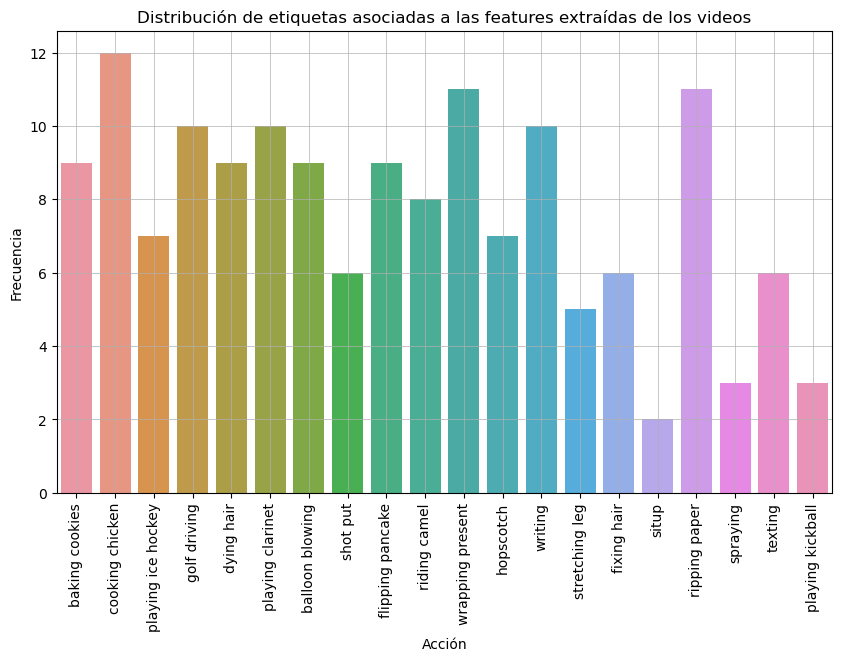

In [48]:
sns.countplot(data = df_train, x = 'action')
plt.xlabel('Acción')
plt.ylabel('Frecuencia')
plt.title('Distribución de etiquetas asociadas a las features extraídas de los videos')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show()

---
## 3. Dimensionality reduction

Usaremos **PCA (Principal Component Analysis)** que nos permitirá reducir la dimensionalidad manteniendo la mayor parte de la varianza de los datos, a mayor cantidad de varianza habrá mayor entropía por lo que por ende seguiremos contando con gran cantidad de **información representativa**. Para hallar la cantidad de componentes correcta usaremos dos métodos, el primero es representar gráficamente la relación que tienen los componentes con la varianza y encontrar una intersección que tenga buena cantidad de varianza y a la vez componentes necesarios.

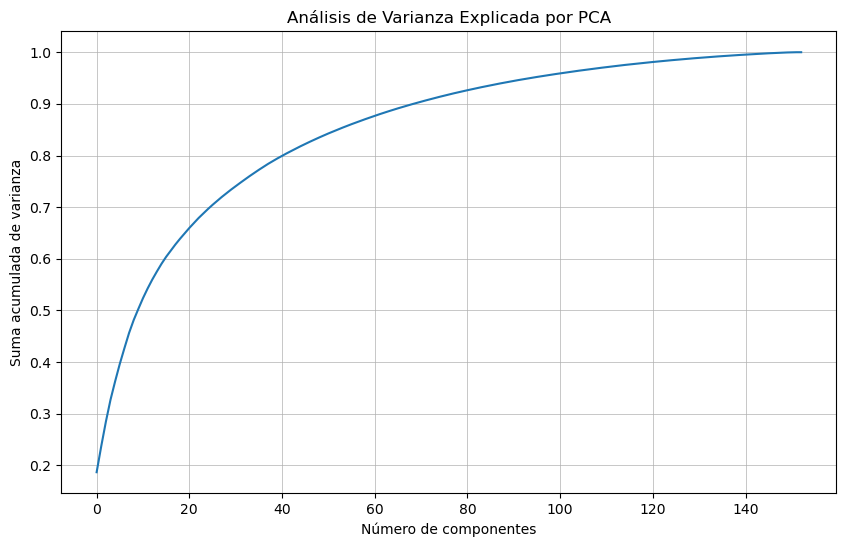

In [14]:
pca = PCA()
pca.fit(video_features_stacked)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Suma acumulada de varianza')
plt.title('Análisis de Varianza Explicada por PCA')
plt.grid(True)
plt.show()

Otro método para hallar las componentes es utilizar operaciones condicionales en numpy para **obtener aquellos índices donde se cumple una condición**, en este caso una cantidad determinada de varianza. Para ello aplicamos la función `np.where` con las condiciones. Evaluamos en un rango del $80\%$ al $90\%$ de modo que al final decantamos por el índice $70$ pues representa un $\approx 90\%$ y se puede observar que se encuentra en el codo con una buena proporción.

In [15]:
pca_sum_variance = np.cumsum(pca.explained_variance_ratio_)

np.where((pca_sum_variance > 0.80) & (pca_sum_variance < 0.90))

n_principal_components = 70
print(f'Número de componentes elegido: {n_principal_components}')

Número de componentes elegido: 70


In [16]:
pca = PCA(n_components = n_principal_components)
video_features_reduced = pca.fit_transform(video_features_stacked)

print(f"Varianza explicada con 50 componentes: {np.sum(pca.explained_variance_ratio_):.2f}")
print(f'Shape después de aplicar PCA: {video_features_reduced.shape}')

Varianza explicada con 50 componentes: 0.90
Shape después de aplicar PCA: (153, 70)


---
### 3. Clustering methods

#### 3.1 Partitioning Method: Median Shift
---
TODO

#### 3.1 Density-based Method: DBSCAN
---
TODO

---
### 4. Classification metrics

TODO